In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import datetime
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Importing 20 Newsgroups dataset

In [2]:
print (str(datetime.datetime.now()) + ": Start importing datasets")
categories = list(fetch_20newsgroups(subset='train').target_names)
no_classes = len(categories)
twenty_train = fetch_20newsgroups(
    subset='train', categories=categories, shuffle=False)
twenty_test = fetch_20newsgroups(
    subset='test', categories=categories, shuffle=False)
print (str(datetime.datetime.now()) + ": End importing datasets")

2020-05-12 00:13:33.350344: Start importing datasets
2020-05-12 00:13:34.324217: End importing datasets


In [3]:
print(twenty_train.data[5])

From: taihou@chromium.iss.nus.sg (Tng Tai Hou)
Subject: ADB and graphics tablet help!
Organization: Institute Of Systems Science, NUS
Lines: 13

Help!!!

I have an ADB graphicsd tablet which I want to connect to my
Quadra 950. Unfortunately, the 950 has only one ADB port and
it seems I would have to give up my mouse.

Please, can someone help me? I want to use the tablet as well as
the mouse (and the keyboard of course!!!).

Thanks in advance.

Tai Hou TNG
Singapore



# Couting terms using tf-idf

In [4]:
tfidf = TfidfVectorizer()
train_x = tfidf.fit_transform(twenty_train.data)  # fit on training data
train_y = twenty_train.target  # train target values
# transform test data to tfidf representation
test_x = tfidf.transform(twenty_test.data)
test_y = twenty_test.target

# Training the Bayes Classifier

In [6]:
from sklearn.naive_bayes import MultinomialNB
modelBayes = MultinomialNB()
modelBayes.fit(train_x, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [7]:
predictedBayes = modelBayes.predict(test_x)

2020-05-12 00:14:29.035120: Bayes Testing accuracy = 0.77390


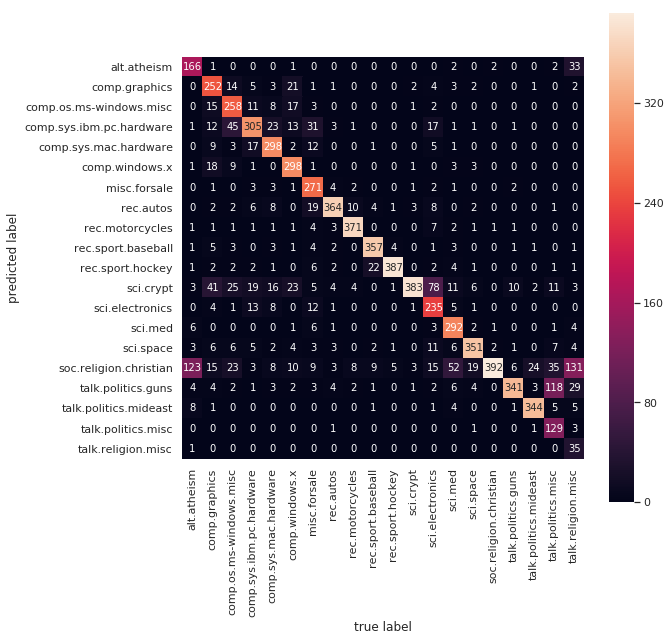

In [8]:
from sklearn.metrics import confusion_matrix
matrixBayes = confusion_matrix(test_y, predictedBayes)

plt.subplots(figsize=(9,9))
sns.heatmap(matrixBayes.T, square=True, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracyBayes = metrics.accuracy_score(test_y, predictedBayes)

print(str(datetime.datetime.now()) +
      ': Bayes Testing accuracy = %.5f' % accuracyBayes)

# Transforming target classes into one-hot vectors

In [9]:
def vector_to_one_hot(vector, no_classes):
    vector = vector.astype(np.int32)
    m = np.zeros((vector.shape[0], no_classes))
    m[np.arange(vector.shape[0]), vector] = 1
    return m


train_y = vector_to_one_hot(train_y, no_classes)
test_y = vector_to_one_hot(test_y, no_classes)

# Configuring Neural Network Parameters

In [9]:
# Parameters
learning_rate = 0.05
num_steps = 500
batch_size = 16
display_step = 100

beta = 1  # regularization parameter
# Network Parameters
n_hidden_1 = 25  # size of 1st hidden layer

num_input = train_x.shape[1]  # input vector size
num_classes = no_classes

tf.disable_v2_behavior()

X = tf.placeholder("float", [None, num_input])  # place holder for nn input
Y = tf.placeholder("float", [None, num_classes])  # place holder for nn output

weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


def neural_net(X):
    layer_1 = tf.add(tf.matmul(X, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    out_layer = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

logits = neural_net(X)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate)

train_step = optimizer.minimize(loss)

# evaluate model
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
y_pred = tf.argmax(logits, 1)
init = tf.global_variables_initializer()


def get_train_batch(batch_size, train_x, train_y):
    global train_index

    if train_index + batch_size >= train_x.shape[0]:
        train_index += batch_size
        # false to indicate no more training batches
        return train_x[train_index:, :], train_y[train_index:, :]
    else:
        r = train_x[train_index:train_index+batch_size,
                    :], train_y[train_index:train_index+batch_size, :]
        train_index += batch_size
        return r

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Starting Neural Network Analysis

In [ ]:
print (str(datetime.datetime.now()) + ": start optimization")

with tf.Session() as sess:
    sess.run(init)
    train_index = 0
    moreTrain = True
    step = 0
    while True:
        step += 1
        if train_index >= train_x.shape[0]:
            break
        batch_x, batch_y = get_train_batch(
            batch_size, train_x.todense(), train_y)
        sess.run(train_step, feed_dict={X: batch_x, Y: batch_y})

        if step % 10 == 0:

            cur_loss, cur_accuracy = sess.run(
                [loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
            print (str(datetime.datetime.now()) + ': loss = %.5f , accuracy = %.5f , at step %d' %
                   (cur_loss, cur_accuracy, step))

    print (str(datetime.datetime.now()) + ": done optimization")
    y_p = sess.run(y_pred, feed_dict={X: test_x.todense(),
                                      Y: test_y})
    print(str(datetime.datetime.now()) + ": Neural Network Testing Accuracy:",
          sess.run(accuracy, feed_dict={X: test_x.todense(),
                                        Y: test_y}))

2020-05-12 00:12:48.704340: start optimization


# Doing the same for SVM

In [11]:
print(str(datetime.datetime.now()) + ": Start SVM tuning")

tuned_parameters = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0, 1]}]


clf = GridSearchCV(SVC(), tuned_parameters, cv=3, n_jobs=4)
clf.fit(train_x, twenty_train.target)

print(str(datetime.datetime.now()) + ": Best parameters set found on development set: ")
print(clf.best_params_)
print(str(datetime.datetime.now()) + ": Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(str(datetime.datetime.now()) + ": %0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print(str(datetime.datetime.now()) + ": End SVM tuning")
predicted = clf.predict(test_x)

accuracySVM = metrics.accuracy_score(twenty_test.target, predicted)

print(str(datetime.datetime.now()) +
      ': SVM Testing accuracy = %.5f' % accuracySVM)

2020-05-07 17:47:16.289458: Start SVM tuning
2020-05-07 18:31:12.776832: Best parameters set found on development set: 
{'C': 10, 'kernel': 'linear'}
2020-05-07 18:31:12.780786: Grid scores on development set:
2020-05-07 18:31:12.782589: 0.653 (+/-0.019) for {'C': 0.1, 'kernel': 'linear'}
2020-05-07 18:31:12.786707: 0.902 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
2020-05-07 18:31:12.786757: 0.904 (+/-0.004) for {'C': 10, 'kernel': 'linear'}
2020-05-07 18:31:12.786789: 0.903 (+/-0.003) for {'C': 100, 'kernel': 'linear'}
2020-05-07 18:31:12.786811: 0.058 (+/-0.013) for {'C': 0.1, 'coef0': 0, 'degree': 2, 'kernel': 'poly'}
2020-05-07 18:31:12.786838: 0.069 (+/-0.045) for {'C': 0.1, 'coef0': 0, 'degree': 3, 'kernel': 'poly'}
2020-05-07 18:31:12.786864: 0.070 (+/-0.048) for {'C': 0.1, 'coef0': 0, 'degree': 4, 'kernel': 'poly'}
2020-05-07 18:31:12.786884: 0.065 (+/-0.035) for {'C': 0.1, 'coef0': 1, 'degree': 2, 'kernel': 'poly'}
2020-05-07 18:31:12.786910: 0.065 (+/-0.035) for {'C': 0.1, '